In [1]:
import pandas as pd
import numpy as np
import os
import glob
import random
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions

from support import *
from features.feature_ts import genX
from experiment.algorithms.cluster_prep import *
from Gauss_fit_functions import extractFIT, extractToPs , gauss, straight_line

C:\Users\MEDIA_LAB\AppData\Local\Programs\Python\Python39\lib\os.py
c:\Users\MEDIA_LAB\thesis_project


# Get Gauss-Fit Features

### Use a small subgroup from the dataset to create feature extraction code
##### The profiles chosen must:
##### - Be typical residential users
##### - Have enough data collected for winter/weekdays
##### - Have a gauss fit with a low error

In [2]:
X = genX([1994,2014],drop_0 = True)

dropping all zero rows


In [3]:
# Collect only winter weekday profiles from dataset

X.reset_index(inplace = True)

df = X.copy()

# Extract Season
df['month'] = df.date.dt.month
df['season'] = df['month'].apply(lambda x: 'winter' if x in [6, 7, 8] else 'summer') 
df_winter = df[df['season'] == 'winter'] # Create dataframe with all the winter months, excluding weekends


# Extract Weekdays
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday','Friday']
df_winter['day_names'] = df_winter.date.dt.day_name()
df_winter['daytype'] = df_winter.day_names.where(~df_winter.day_names.isin(weekdays), 'weekday')
df_winter.drop(['day_names'], axis = 1, inplace = True)
df_winter_weekdays  = df_winter[df_winter['daytype'] == 'weekday'] # Create dataframe with only weekdays
df_winter_weekdays.drop(['month', 'season','daytype'], axis = 1, inplace = True)
df_winter_weekdays.set_index(['ProfileID','date'], inplace=True)

C:\Users\MEDIA_~1\AppData\Local\Temp/ipykernel_10568/2621424369.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\MEDIA_~1\AppData\Local\Temp/ipykernel_10568/2621424369.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\MEDIA_LAB\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

### Get households that pass the stictily residential test

In [4]:
mean = df_winter_weekdays.groupby(["ProfileID"]).mean()

# Test 1: Energy between 9-5 
i = np.arange(9,17)
sum_df = pd.DataFrame(index = mean.index, columns = ["9_to_5", 'total'])
sum_df = sum_df.fillna(0)
for x in i:
    temp = mean.iloc[:,x]
    sum_df['9_to_5'] = sum_df['9_to_5'] + temp

sum_df['total'] =  mean.sum(axis = 1)

sum_df["percentage"] = (sum_df["9_to_5"]/sum_df["total"]) * 100

def check_9_to_5(df):
    if df > 50:
        return 'B'
    else: 
        return 'R'

sum_df['Labels'] = sum_df['percentage'].apply(check_9_to_5)

# 173 households labeled as Businesses for the 9-to-5 check
sum_df[sum_df['percentage'] > 50]

,9_to_5,total,percentage,Labels
ProfileID,,,,
66,7.314488,14.168734,51.624145,B
217,29.234047,48.776469,59.934734,B
221,11.493651,22.538165,50.996394,B
232,46.414889,88.394214,52.508967,B
284,22.920155,44.093986,51.980230,B
...,...,...,...,...
12028369,19.029901,37.612317,50.594864,B
12028403,6.608640,8.126843,81.318658,B
12028447,24.028575,45.127989,53.245392,B


In [5]:
# Tests 2: ToP
top_df = pd.DataFrame()

top_df['Time'] = mean.idxmax(axis=1)

def check_top(df):
    if int(df) > 9 and int(df) < 17:
        return 'B'
    else:
        return 'R'  

top_df['Labels'] = top_df['Time'].apply(check_top)

### Extract households that are residential according to test

In [6]:
new_df = pd.DataFrame()

new_df['ToP'], new_df['Sum'] = top_df['Labels'], sum_df['Labels']

data_classes = ['R','B']
d = dict(zip(data_classes, range(0,2)))

new_df['ToP'],new_df['Sum'] = new_df['ToP'].map(d, na_action='ignore'),new_df['Sum'].map(d, na_action='ignore')

new_df['Total'] = new_df.sum(axis = 1)

In [7]:
residential_ids = new_df[new_df['Total'] == 0].index.values # Contains the profile ids that have typical residential behaviour

# Extract Residential households that have complete data
### Housholds must have:
### - Atleast 3 months of winter weekday data, i.e. +-60 days of data

In [8]:
df_winter_weekdays.reset_index(inplace = True)

In [9]:
# Remove all households with less than three winter months
winter_months_ids = []

for i in df_winter_weekdays['ProfileID'].unique():
    if len(df_winter_weekdays[df_winter_weekdays['ProfileID'] == i]) >= 30:

        winter_months_ids.append(i) # Contains the profile Ids that have a complete winter months data

winter_months_ids = np.asarray(winter_months_ids)

In [10]:
profileIDs = np.intersect1d(winter_months_ids, residential_ids)

# Filter out all the ids from the above two extractions steps

In [11]:
cleaned_df = df_winter_weekdays[df_winter_weekdays['ProfileID'].isin(profileIDs)]
cleaned_df.head()

,ProfileID,date,0,1,2,3,4,5,6,7,...,14,15,16,17,18,19,20,21,22,23
0,1,1994-06-20,1.058333,1.625000,0.341667,2.100000,1.225000,1.058333,4.808333,4.091667,...,1.433333,2.641667,2.116667,5.541667,5.275000,6.533333,4.708333,10.433333,9.508333,4.408333
1,1,1994-06-21,0.425000,2.350000,0.550000,0.291667,2.100000,0.591667,4.066667,2.791667,...,3.150000,1.825000,4.016667,1.833333,3.466667,8.875000,10.850000,12.908333,9.241667,2.625000
2,1,1994-06-22,0.741667,2.325000,0.583333,1.191667,1.225000,0.575000,4.066667,3.350000,...,1.500000,0.933333,2.791667,6.291667,6.491667,4.458333,13.125000,10.750000,6.200000,1.350000
3,1,1994-06-23,1.166667,1.883333,0.450000,0.541667,2.333333,0.341667,4.216667,2.341667,...,2.666667,4.758333,2.391667,5.233333,3.250000,5.958333,10.466667,10.066667,5.016667,0.733333
4,1,1994-06-24,2.408333,0.591667,0.316667,2.341667,0.550000,1.183333,3.783333,2.958333,...,5.400000,1.041667,4.083333,3.191667,2.216667,4.258333,2.725000,0.975000,1.216667,1.608333


# Extract gauss_fit features
### Extract the mean amplitudes
### Sigma values
### Mean amplitude deviation
### Mean Daily consumptions
### Deviation in daily consumption
### Time of peaks


In [12]:
reduced_list = random.choices(profileIDs,k = 20)

In [13]:
# Create Dataframe
cols = ['ProfileID','H_offset','sigma1','sigma2','mu1','A1','sigma3','sigma4','mu2','A2']

# cols = pd.MultiIndex.from_tuples([("ProfileID",''),
#                                 ('H_offset', 'H_offset'),
#                                  ("Morning", "sigma1"), 
#                                   ("Morning", "sigma2"), 
#                                   ("Morning", "mu1"),
#                                   ("Morning", "A1"),
#                                   ("Afternoon", "sigma3"), 
#                                   ("Afternoon", "sigma4"), 
#                                   ("Afternoon", "mu2"),
#                                   ("Afternoon", "A2")])

# Create dummy variables
H_offset = 0
sigma1 = 0
sigma2 = 0 
mu1 = 0
A1 = 0 
sigma3 = 0 
sigma4 = 0 
mu2 = 0
A2 = 0

data=[['DROP_ROW',H_offset,sigma1,sigma2, mu1, A1, sigma3, sigma4, mu2,A2]]

gauss_df = pd.DataFrame(data, columns=cols)

# reduced_list = [1005615]
for id in tqdm(reduced_list):
    H_offset,sigma1, sigma2, mu1, A1, sigma3, sigma4, mu2, A2, check = extractFIT(cleaned_df,id)
    print(check)
    if check == False:
        continue

    data=[[id,H_offset,sigma1,sigma2, mu1, A1, sigma3, sigma4, mu2,A2]]
    temp_df = pd.DataFrame(data, columns=cols)
    temp_df.set_index(['ProfileID'])
    gauss_df = gauss_df.append(temp_df)

gauss_df = gauss_df.set_index(['ProfileID'])

# Store Gaussian Fit features
temp = gauss_df.copy()
temp.drop(['DROP_ROW'],axis = 0, inplace = True)
# # # temp.to_csv('FitFeatures_1200_2500.csv')

C:\Users\MEDIA_~1\AppData\Local\Temp/ipykernel_10568/3266001112.py:31: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/20 [00:00<?, ?it/s]

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


# Extract the amplitude of every day for each profile

In [14]:
# reduced_list = random.choices(profileIDs,k = 10)

In [15]:
t = cleaned_df[cleaned_df['ProfileID'] == 5]
t_series = t.iloc[0]
t_series.drop(labels = ['date'], inplace = True)
t_frame = t_series.to_frame()
t_frame = t_frame.T
t_frame.reset_index(inplace = True)
t_frame.drop(['index'], axis = 1, inplace = True)
t_frame.set_index(['ProfileID'], inplace = True)
t_frame
# df = df.drop(labels = ['ProfileID', 'date'])

C:\Users\MEDIA_LAB\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\generic.py:4150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
ProfileID,,,,,,,,,,,,,,,,,,,,,
5,2.97775,1.069333,1.363583,2.370667,1.098,2.6325,7.26575,8.111167,11.583917,9.582167,...,9.444333,17.527,13.849,11.341917,9.104583,15.9335,17.159333,6.229917,4.240667,4.9265


In [16]:
# Create cols
cols = ['ProfileID','A1','A2','mu1','mu2']

# Create dummy variables
mu1 = 0
A1 = 0 
mu2 = 0
A2 = 0

data=[['DROP_ROW',A1,A2,mu1,mu2]]

amplitudes_df = pd.DataFrame(data, columns=cols)

for id in reduced_list:
    for index in cleaned_df[cleaned_df['ProfileID'] == id].index:
        A1, A2, mu1, mu2, check = extractToPs(cleaned_df[cleaned_df['ProfileID'] == id].loc[index])
        if check == False:
            continue
        
        data=[[id,A1,A2,mu1,mu2]]
        temp_df = pd.DataFrame(data, columns=cols)
        # temp_df.set_index(['ProfileID'])
        amplitudes_df = amplitudes_df.append(temp_df)
    
amplitudes_df = amplitudes_df.set_index(['ProfileID'])
temporary = amplitudes_df.copy()
temporary.drop(['DROP_ROW'],axis = 0, inplace = True)
    

In [17]:
temporary

,A1,A2,mu1,mu2
ProfileID,,,,
1002851,0.998750,3.891833,8,19
1002851,2.320750,5.665583,7,20
1002851,1.602583,5.965083,8,21
1002851,3.275667,6.551000,7,20
1002851,3.081000,1.406250,8,20
...,...,...,...,...
10216,0.007167,0.938167,1,20
10216,0.386000,0.874917,1,19
10216,0.027417,0.928667,5,19


# Calculate the amplitude deviations

In [18]:
def standard_deviation(my_list):
    #calculate population standard deviation of list 
    return (sum((x-(sum(my_list) / len(my_list)))**2 for x in my_list) / len(my_list))**0.5

In [19]:
daily_consumption = pd.DataFrame()

daily_consumption['Daily_Consumption'] = cleaned_df.set_index(["ProfileID"]).sum(axis = 1)

std_deviation_df = pd.DataFrame(index = temporary.index.unique())

for id in temporary.index.unique():
    std_deviation_df.loc[id,'A1_std'] = standard_deviation(temporary.loc[id]['A1'])
    std_deviation_df.loc[id,'A2_std'] = standard_deviation(temporary.loc[id]['A2'])
    std_deviation_df.loc[id,'mu1_std'] = standard_deviation(temporary.loc[id]['mu1'])
    std_deviation_df.loc[id,'mu2_std'] = standard_deviation(temporary.loc[id]['mu2'])
    std_deviation_df.loc[id,'DC_std'] = standard_deviation(daily_consumption.loc[id]['Daily_Consumption'])


C:\Users\MEDIA_~1\AppData\Local\Temp/ipykernel_10568/921994390.py:3: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



In [20]:
temporary

,A1,A2,mu1,mu2
ProfileID,,,,
1002851,0.998750,3.891833,8,19
1002851,2.320750,5.665583,7,20
1002851,1.602583,5.965083,8,21
1002851,3.275667,6.551000,7,20
1002851,3.081000,1.406250,8,20
...,...,...,...,...
10216,0.007167,0.938167,1,20
10216,0.386000,0.874917,1,19
10216,0.027417,0.928667,5,19


In [21]:
std_deviation_df

,A1_std,A2_std,mu1_std,mu2_std,DC_std
ProfileID,,,,,
1002851,1.407846,1.755873,1.705872,1.579359,12.374355
10449,2.202750,2.303126,1.919567,2.505511,10.051127
1004500,0.530751,1.681234,1.562182,1.505847,4.084126
8004,1.505125,1.365014,1.203328,2.016060,12.132932
12008609,4.453379,5.117777,1.348767,1.904837,58.444368
776,0.525921,0.373984,0.470334,1.100631,1.584597
11149,3.766596,6.870854,1.710808,2.032633,46.651975
10437,1.136535,1.492110,1.508991,1.855400,6.827484
1003032,0.947406,1.618582,2.076345,2.291097,6.698924


# Combine the features extracted for the synthetic profiles

In [22]:
# std_deviation_df
# temp.columns = temp.columns.droplevel(0)
temp
combined_df = pd.merge(temp,std_deviation_df, left_index = True, right_index = True)

In [23]:
len(combined_df)

20

# Check the distribution of the amplitude and Time

In [24]:
import re
import pandas as pd
import numpy as np
# from mlutils import dataset, connector
import scipy.stats
from scipy.stats import *
from sklearn.preprocessing import StandardScaler
import math
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm 
import seaborn as sns
import pylab as py 
warnings.filterwarnings('ignore')
%matplotlib inline

In [25]:
dist_names = ["weibull_min","norm","weibull_max","beta",
              "invgauss","uniform","gamma","expon",   
              "lognorm","pearson3","triang"]

In [26]:
def standarise(df,column,pct,pct_lower):    
    sc = StandardScaler() 
    y = df[column][df[column].notnull()].to_list()
    y.sort()
    len_y = len(y)
    y = y[int(pct_lower * len_y):int(len_y * pct)]
    len_y = len(y)
    yy=([[x] for x in y])
    sc.fit(yy)
    y_std =sc.transform(yy)
    y_std = y_std.flatten()
    return y_std,len_y,y

In [27]:
def fit_distribution(df,column,pct,pct_lower):
    # Set up list of candidate distributions to use
    # See https://docs.scipy.org/doc/scipy/reference/stats.html for more
    y_std,size,y_org = standarise(df,column,pct,pct_lower)
    print(df)
    print(y_std)
    dist_names = ['weibull_min','norm','weibull_max','beta',
                    'invgauss','uniform','gamma','expon', 'lognorm','pearson3','triang']
    y_std = y_org

    chi_square_statistics = []
    parameters = []
    # 11 bins
    percentile_bins = np.linspace(0,100,11)
    percentile_cutoffs = np.percentile(y_std, percentile_bins)
    observed_frequency, bins = (np.histogram(y_std, bins=percentile_cutoffs))
    cum_observed_frequency = np.cumsum(observed_frequency)

    # Loop through candidate distributions

    for distribution in dist_names:
        # Set up distribution and get fitted distribution parameters
        dist = getattr(scipy.stats, distribution)
        print(dist)
        param = dist.fit(y_std)
        # print("{}\n{}\n".format(dist, param))
        parameters.append(param)

        # Get expected counts in percentile bins
        # cdf of fitted distrinution across bins
        cdf_fitted = dist.cdf(percentile_cutoffs, *param)
        expected_frequency = []
        for bin in range(len(percentile_bins)-1):
            expected_cdf_area = cdf_fitted[bin+1] - cdf_fitted[bin]
            expected_frequency.append(expected_cdf_area)

        # Chi-square Statistics
        expected_frequency = np.array(expected_frequency) * size
        cum_expected_frequency = np.cumsum(expected_frequency)
        ss = round(sum (((cum_expected_frequency - cum_observed_frequency) ** 2) / cum_observed_frequency),0)
        chi_square_statistics.append(ss)


    #Sort by minimum ch-square statistics
    results = pd.DataFrame()
    results['Distribution'] = dist_names
    results['chi_square'] = chi_square_statistics
    results['params'] = parameters
    results.sort_values(['chi_square'], inplace=True)


    # print ('\nDistributions listed by Betterment of fit:')
    # print ('............................................')
    # print (results)
    return results.iloc[0]

### Check which distribution describes the data best

In [28]:
profiles_ids = temporary.index.unique().values

cols = pd.MultiIndex.from_tuples([#("ProfileID",''),
                                ('A1', 'Distribution'),
                                 ("A1", "chi_square"), 
                                  ("A1", "params"), 
                                  ("A2", "Distribution"),
                                  ("A2", "chi_square"),
                                  ("A2", "params") 
                                  #, ('t1', 'Distribution'),
                                  # ("t1", "chi_square"), 
                                  # ("t1", "params"), 
                                  # ("t2", "Distribution"),
                                  # ("t2", "chi_square"),
                                  # ("t2", "params"),
                                ])
distributions_df = pd.DataFrame(index = profiles_ids,columns = cols)
results = []
for id in profiles_ids:
    # Extract the best distribution fitted
    results1 = fit_distribution(temporary.loc[id],'A1',0.99,0.01)
    results2 = fit_distribution(temporary.loc[id],'A2',0.99,0.01)
    # results3 = fit_distribution(temporary.loc[id],'mu1',0.99,0.01)
    # results4 = fit_distribution(temporary.loc[id],'mu2',0.99,0.01)

    results = [results1.values[0],results1.values[1],results1.values[2], results2.values[0],results2.values[1],results2.values[2]]
              # ,results3.values[0],results3.values[1],results3.values[2], results4.values[0],results4.values[1],results4.values[2]]

    distributions_df.loc[id] = results


                 A1        A2  mu1  mu2
ProfileID                              
1002851    0.998750  3.891833    8   19
1002851    2.320750  5.665583    7   20
1002851    1.602583  5.965083    8   21
1002851    3.275667  6.551000    7   20
1002851    3.081000  1.406250    8   20
1002851    1.242000  2.766083    9   18
1002851    2.246583  3.853667    7   20
1002851    2.571167  3.811083    9   20
1002851    1.134833  0.528917    6   22
1002851    0.183333  0.533917    9   22
1002851    0.172417  0.875583    9   20
1002851    0.395917  5.027917    2   18
1002851    3.958667  4.446667    7   19
1002851    3.379583  4.951417    7   19
1002851    3.291833  3.976917   10   20
1002851    2.114917  3.529167   10   19
1002851    2.352750  3.983833    9   20
1002851    3.757667  4.215083    4   19
1002851    3.426167  4.191500    8   19
1002851    3.615250  4.565250    7   20
1002851    4.085917  3.483917    7   21
1002851    2.641333  4.145083    8   19
1002851    4.405417  4.177250    6   20


## Plot the theoretical vs actual cumulative distributions

In [29]:
# level_0 = distributions_df.columns.get_level_values(0).unique()
# houseID = 1003093
# for column in level_0:

#     distributions = distributions_df[column].loc[houseID]['Distribution']
#     parameters = distributions_df[column].loc[houseID]['params']

#     if distributions == 'invgauss':
#         print('invgauss')
#         data_points = invgauss.rvs(parameters[0], parameters[1], parameters[2],size = 2000)
#     elif distributions == 'weibull_min':
#         print('weibull_min')
#         data_points = weibull_min.rvs(parameters[0], parameters[1], parameters[2], size = 2000)
#     elif distributions == 'weibull_max':
#         print('weibull_max')
#         data_points = weibull_max.rvs(parameters[0], parameters[1], parameters[2], size = 2000)
#     elif distributions == 'beta':
#         print('beta')
#         data_points == beta.rvs(parameters[0], parameters[1], parameters[2],parameters[3], size = 2000)
#     elif distributions == 'norm':
#         print('norm')
#         data_points = norm.rvs(parameters[0], parameters[1], 2000)

#     y_std,len_y,y = standarise(temporary.loc[houseID],column,0.99,0.01)
    
#     y_std = y

#     f, ax = plt.subplots(figsize=(8,8))
#     ax.plot([-2, 8], [-2, 8], ls="--", c=".3")

#     percentile_bins = np.linspace(0,100,51)
#     percentile_cutoffs1 = np.percentile(y_std, percentile_bins)

#     percentile_cutoffs = np.percentile(data_points, percentile_bins)

#     ax.scatter(percentile_cutoffs1,percentile_cutoffs,c='r',label = distributions + ' Distribution',s = 40)
#     ax.set_title('Cumulative Distribution ' + column + ' theo vs obs.') 
#     ax.set_xlabel('Theoretical cumulative distribution')
#     ax.set_ylabel('Observed cumulative distribution')
#     ax.legend()
#     plt.show()

# Create synthetic profile for a single user

### Function to reverse the standardisation process used when fitting distribution to data

In [30]:
def inverse_StandardScalar(data_points,df,column,pct,pct_lower):
    sc = StandardScaler() 
    y = df[column][df[column].notnull()].to_list()
    y.sort()
    len_y = len(y)
    y = y[int(pct_lower * len_y):int(len_y * pct)]
    len_y = len(y)
    yy=([[x] for x in y])
    sc.fit(yy)
    y_std = sc.transform(yy)
    y_std = y_std.flatten()

    inversed_data_points = sc.inverse_transform(data_points)

    return inversed_data_points

In [31]:
# distributions = distributions_df['A1'].loc[houseID]['Distribution']
# parameters = distributions_df['A1'].loc[houseID]['params']
# data_points = weibull_max.rvs(parameters[0], parameters[1], parameters[2], size = 60)
# inverse_data_points = inverse_StandardScalar(data_points,temporary.loc[id],'A1',0.99,0.01)

### Verify that inverse_StandardScalar works

In [32]:
# inv_data_df = pd.DataFrame(inverse_data_points)
# temp_df = pd.DataFrame(temporary['A1'].values)
# inv_data_df.columns = ['A1']
# temp_df.columns = ['A1']
# inv_data_df['label'] = 'synth'
# temp_df['label'] = 'observed'
# synth_obs_df = temp_df.append(inv_data_df, ignore_index = True)
# sns.displot(data = synth_obs_df, x= 'A1',  stat="density", hue = 'label').set(title = 'Distribution Plot: A1 Obs. vs. Theo')

### Construct the Synthetic profile generator

In [33]:
# Define function that approximates straight line
def straight_line(m,x,b):
    return m*x+b

### First generate the synthetic amplitude values

In [34]:
# houseID = 12005159
level_0 = distributions_df.columns.get_level_values(0).unique()
# data_pointA1 = pd.DataFrame()
# data_pointA2 = pd.DataFrame()
inv_data_df = pd.DataFrame()
temp_df_inv = pd.DataFrame()
for houseID in distributions_df.index:
    for column in level_0:

        distributions = distributions_df[column].loc[houseID]['Distribution']
        parameters = distributions_df[column].loc[houseID]['params']

        loc = combined_df.loc[houseID][column]
        scale = combined_df.loc[houseID][column + '_std']  
        size = 1000
        if distributions == 'invgauss':
            print('invgauss')
            data_points = invgauss.rvs(parameters[0], parameters[1], parameters[2],size = size)
        elif distributions == 'weibull_min':
            print('weibull_min')
            data_points = weibull_min.rvs(parameters[0], parameters[1], parameters[2], size = size)
        elif distributions == 'weibull_max':
            print('weibull_max')
            print(f'loc = {loc}, scale = {scale}')
            data_points = weibull_max.rvs(parameters[0], loc = loc, scale = scale, size = size)
            # data_points = weibull_max.rvs(parameters[0], parameters[1], parameters[2], size = 60)
        elif distributions == 'beta':
            print('beta')
            data_points = beta.rvs(parameters[0], parameters[1], loc = loc,scale = scale, size = size)
            # data_points = beta.rvs(parameters[0], parameters[1], parameters[2],parameters[3], size = 60)
        elif distributions == 'norm':
            print('norm')
            data_points = norm.rvs(parameters[0], parameters[1], size = size)
        elif distributions == 'triang':
            print('triang')
            data_points = triang.rvs(parameters[0], loc = loc,scale = scale, size = size)
        elif distributions == 'pearson3':
            print('pearson3')
            data_points = pearson3.rvs(parameters[0], loc = loc,scale = scale, size = size)
        elif distributions == 'lognorm':
            print('lognorm')
            data_points = lognorm.rvs(parameters[0], loc = loc,scale = scale, size = size)
        elif distributions == 'uniform':
            print('uniform')
            data_points = uniform.rvs(loc = loc,scale = scale, size = size)
        elif distributions == 'expon':
            print('expon')
            data_points = expon.rvs(loc = loc,scale = scale, size = size)
        elif distributions == 'gamma':
            print('gamma')
            data_points = gamma.rvs(parameters[0], loc = loc,scale = scale, size = size)

        # print(column)
        # inverse_data_points = inverse_StandardScalar(data_points,temporary.loc[id],column,0.99,0.01)
        temp_df_inv['ProfileID'] = houseID
        temp_df_inv[column] = data_points#inverse_data_points
        
    inv_data_df = inv_data_df.append(temp_df_inv)
        # if column == 'A1':
        #     data_pointA1 = data_points#inverse_data_points
        # elif column == 'A2':
        #     data_pointsA2 = data_points#inverse_data_points

inv_data_df = inv_data_df.dropna()
inv_data_df.set_index(['ProfileID'], inplace = True)

uniform
weibull_max
loc = 2.2678118686868687, scale = 1.7558730147666919
invgauss
invgauss
weibull_min
invgauss
triang
norm
beta
beta
weibull_min
weibull_max
loc = 1.5111150783560579, scale = 0.37398440032075114
beta
pearson3
beta
beta
beta
weibull_min
beta
norm
beta
uniform
weibull_min
invgauss
invgauss
beta
beta
beta
weibull_min
weibull_min
beta
norm
pearson3
beta
weibull_min
weibull_min
beta
weibull_min
invgauss
weibull_min


In [35]:
loc = combined_df.loc[houseID]['A2']
scale = combined_df.loc[houseID]['A2_std']

In [36]:
A1 =  inv_data_df.loc[houseID]['A1']
A1 = pd.DataFrame(A1)

In [37]:
A1

,A1
ProfileID,
10216,0.005596
10216,0.010504
10216,0.008457
10216,0.141513
10216,0.008785
...,...
10216,0.009987
10216,0.054030
10216,0.300360


In [38]:
A1 = inv_data_df.loc[houseID]['A1']
A2 = inv_data_df.loc[houseID]['A2']
A1 = pd.DataFrame(A1)
A1.reset_index(inplace=True)
A2 = pd.DataFrame(A2)
A2.reset_index(inplace=True)
i = 0
for each1,each2 in zip(A1.A1.iteritems(), A2.A2.iteritems()):
    if i == 0:
        each1 = each1[1]
        # each2 = each2
        print(each1)
        # print(each2)    
        # i = 1
    
    # print(each)


0.005595924749777303
0.0105037186327487
0.008456751461201603
0.14151281275793917
0.008785365204003937
0.2382436735247272
0.17606746411533258
0.016166071835655306
0.013343211932511503
0.005396269577165991
0.005578974789155977
0.03357122583110308
0.027016041473908944
0.01478329018220993
0.03429843428822261
0.005950285911540197
0.015283920936676203
0.006775812890181955
0.041698194690126714
0.007672413259517955
0.01426974426469276
0.005909163053759639
0.007478790600871116
0.007737469791226996
0.02534933404195225
0.006736721287509507
0.04119162941304855
0.007700344177646139
0.017272676987393383
0.036047177784710976
0.14843144649331239
0.007505056927274229
0.007272379140273481
0.01768135144357466
0.015440801476214745
0.007755280066224358
0.013149785254296716
0.013379415561007831
0.006074680013045765
0.04816070882126776
0.00587837628708396
0.014332647496962354
0.008834643956863654
0.02552026307908161
0.15212906807761797
0.0747690975602065
0.019315958943921508
0.06512676306425266
0.01484349499

In [46]:
def generate_synth_profiles2(A1,A2,mu1,mu2):    
    # Straight line approximation between: mu1 + 4 to mu2 - 4
    # Determine the complete synthetic profile
    
    
    x_1 = np.arange(0,mu1,1)
    x_2 = np.arange(mu1,mu1+3,1)
    x_3 = np.arange(mu2-3,mu2+1,1)
    x_4 = np.arange(mu2,23,1)

    x_vals = np.hstack((x_1,x_2,x_3,x_4))
    x_vals_1 = np.unique(x_vals)
    synthetic_df2 = pd.DataFrame()
    i = 0
    for A1_item, A2_item in zip(A1.A1.iteritems(), A2.A2.iteritems()):
        i += 1
        gauss1 = gauss(x_1, H_offset , A1_item[1], mu1, sigma1)
        gauss2 = gauss(x_2, H_offset, A1_item[1], mu1, sigma2)
        gauss3 = gauss(x_3, H_offset, A2_item[1], mu2, sigma3)
        gauss4 = gauss(x_4, H_offset , A2_item[1], mu2, sigma4)


        i2 = mu1 + 3
        i3 = mu2 - 3

        if len(x_vals_1) == 24:
                # print("Entire array is captured")
                if x_2[-1] == x_3[0]:
                    x_3 = x_3[1:] # Remove the first value of the x-array
                    y3 = gauss(x_3, H_offset,A2_item[1],mu2,sigma3) # Re-calculate the y-values for gauss 3
                    synth = np.hstack((gauss1,gauss2,gauss3,gauss4)) # Generate the synthetic values
                else:
                    synth = np.hstack((gauss1,gauss2,gauss3,gauss4)) # If there is no repeating values in x_2 and x_3 then generate synthetic profiles without adjusting x_3's values

        else:
            # print("Missing hours need to be saved")
            x_5 = np.arange(i2,i3,1)
            x_vals_1 = np.hstack((x_1,x_2,x_5,x_3,x_4))
            x_vals_1 = np.unique(x_vals_1)

            # Synthesize the mid range behaviour
            m = (gauss(x_3[0], H_offset,A2_item[1],mu2,sigma3) - gauss(x_2[-1], H_offset,A1_item[1],mu1,sigma2))/(x_3[0]-x_2[-1]) # Calculate slope
            b = gauss(x_3[0], H_offset,A2_item[1],mu2,sigma3) - m*x_3[0] # Calculate b constant for straight line equation
            y_mid = straight_line(m,x_5,b)

            synth = np.hstack((gauss1,gauss2,y_mid,gauss3,gauss4))

        data = [[i,synth.tolist()]]
        temp = pd.DataFrame(data)
        synthetic_df2 = synthetic_df2.append(temp)
        
    synthetic_df2 = synthetic_df2.loc[:,1].apply(pd.Series)
    synthetic_df2 = synthetic_df2.loc[:,0].merge(synthetic_df2, right_index = True, left_index = True)
    return synthetic_df2

In [51]:
synthetic_df = pd.DataFrame()
for id in distributions_df.index.unique():
    houseID = id

    H_offset = combined_df.loc[houseID]['H_offset']

    mu1 = combined_df.loc[houseID]['mu1']
    mu2 = combined_df.loc[houseID]['mu2']

    sigma1 = combined_df.loc[houseID]['sigma1']
    sigma2 = combined_df.loc[houseID]['sigma2']
    sigma3 = combined_df.loc[houseID]['sigma3']
    sigma4 = combined_df.loc[houseID]['sigma4']

    A1 = inv_data_df.loc[houseID]['A1']
    A2 = inv_data_df.loc[houseID]['A2']
    A1 = pd.DataFrame(A1)
    A2 = pd.DataFrame(A2)
    A1 = A1- H_offset
    A2 = A2-H_offset

    A1.reset_index(inplace=True)
    A2.reset_index(inplace=True)


    synth = generate_synth_profiles2(A1,A2,mu1,mu2)
    # temp = pd.DataFrame(synth)
    # temp = temp.T
    synthetic_df = synthetic_df.append(synth)
    synthetic_df

    # synth_mean = synthetic_df.groupby(['ProfileID']).mean()

In [52]:
synth

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,14_y,15_y,16_y,17_y,18_y,19_y,20_y,21_y,22_y,23_y
0,0.00648,0.00648,0.00648,0.005596,0.005825,0.006214,0.018922,0.031630,0.044337,0.057045,...,0.120584,0.133291,0.145999,0.407676,0.762599,0.940454,0.940454,0.786601,0.461094,0.191313
0,0.00648,0.00648,0.00648,0.005596,0.005825,0.006214,0.018922,0.031630,0.044337,0.057045,...,0.157566,0.174219,0.190872,0.536710,1.005786,1.240843,1.240843,1.037507,0.607309,0.250759
0,0.00648,0.00648,0.00648,0.005596,0.005825,0.006214,0.018922,0.031630,0.044337,0.057045,...,0.081027,0.089244,0.097461,0.268102,0.499549,0.615530,0.615530,0.515201,0.302936,0.127010
0,0.00648,0.00648,0.00648,0.005596,0.005825,0.006214,0.018922,0.031630,0.044337,0.057045,...,0.152274,0.163960,0.175646,0.492927,0.923270,1.138918,1.138918,0.952372,0.557697,0.230588
0,0.00648,0.00648,0.00648,0.005596,0.005825,0.006214,0.018922,0.031630,0.044337,0.057045,...,0.149054,0.164818,0.180582,0.507122,0.950023,1.171964,1.171964,0.979974,0.573782,0.237128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.00648,0.00648,0.00648,0.213211,0.159582,0.068669,0.076719,0.084769,0.092820,0.100870,...,0.117857,0.130115,0.142373,0.397248,0.742946,0.916179,0.916179,0.766324,0.449278,0.186508
0,0.00648,0.00648,0.00648,0.213211,0.159582,0.068669,0.076719,0.084769,0.092820,0.100870,...,0.074381,0.080336,0.086292,0.235983,0.439016,0.540757,0.540757,0.452746,0.266541,0.112213
0,0.00648,0.00648,0.00648,0.213211,0.159582,0.068669,0.076719,0.084769,0.092820,0.100870,...,0.123991,0.127225,0.130459,0.362989,0.678379,0.836424,0.836424,0.699708,0.410457,0.170725
0,0.00648,0.00648,0.00648,0.213211,0.159582,0.068669,0.076719,0.084769,0.092820,0.100870,...,0.128236,0.141393,0.154550,0.432264,0.808940,0.997696,0.997696,0.834413,0.488957,0.202641


In [53]:
synthetic_df

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,14_y,15_y,16_y,17_y,18_y,19_y,20_y,21_y,22_y,23_y
0,0.32310,0.327304,0.345937,0.409784,0.577307,0.908228,1.383734,1.838367,2.029665,0.32225,...,0.437943,0.466867,0.495790,0.524713,0.681183,0.828323,0.889724,0.889724,0.738430,0.486417
0,0.32310,0.327304,0.345937,0.409784,0.577307,0.908228,1.383734,1.838367,2.029665,0.32225,...,0.270284,0.257292,0.244301,0.231309,0.161027,0.094936,0.067356,0.067356,0.135313,0.248511
0,0.32310,0.327304,0.345937,0.409784,0.577307,0.908228,1.383734,1.838367,2.029665,0.32225,...,0.560269,0.619773,0.679278,0.738783,1.060691,1.363406,1.489729,1.489729,1.178467,0.659995
0,0.32310,0.327304,0.345937,0.409784,0.577307,0.908228,1.383734,1.838367,2.029665,0.32225,...,0.373852,0.386753,0.399653,0.412554,0.482343,0.547971,0.575358,0.575358,0.507877,0.395473
0,0.32310,0.327304,0.345937,0.409784,0.577307,0.908228,1.383734,1.838367,2.029665,0.32225,...,0.653059,0.735761,0.818463,0.901165,1.348568,1.769295,1.944864,1.944864,1.512259,0.791662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.00648,0.006480,0.006480,0.213211,0.159582,0.068669,0.076719,0.084769,0.092820,0.10087,...,0.117857,0.130115,0.142373,0.397248,0.742946,0.916179,0.916179,0.766324,0.449278,0.186508
0,0.00648,0.006480,0.006480,0.213211,0.159582,0.068669,0.076719,0.084769,0.092820,0.10087,...,0.074381,0.080336,0.086292,0.235983,0.439016,0.540757,0.540757,0.452746,0.266541,0.112213
0,0.00648,0.006480,0.006480,0.213211,0.159582,0.068669,0.076719,0.084769,0.092820,0.10087,...,0.123991,0.127225,0.130459,0.362989,0.678379,0.836424,0.836424,0.699708,0.410457,0.170725
0,0.00648,0.006480,0.006480,0.213211,0.159582,0.068669,0.076719,0.084769,0.092820,0.10087,...,0.128236,0.141393,0.154550,0.432264,0.808940,0.997696,0.997696,0.834413,0.488957,0.202641


#### Amplitude values

In [ ]:
A1 = inv_data_df['A1']
A2 = inv_data_df['A2']
H_offset = combined_df.loc[houseID]['H_offset']

A1 = A1- H_offset
A2 = A2-H_offset

#### Next, generate the time of peak values:

In [ ]:
mu1 = combined_df.loc[houseID]['mu1']
mu2 = combined_df.loc[houseID]['mu2']

#### Then, create the shape of the profiles

In [ ]:
sigma1 = combined_df.loc[houseID]['sigma1']
sigma2 = combined_df.loc[houseID]['sigma2']
sigma3 = combined_df.loc[houseID]['sigma3']
sigma4 = combined_df.loc[houseID]['sigma4']

# gauss1 = gauss(np.arange(0,mu1,1), H_offset , A1[0], mu1, sigma1)
# gauss2 = gauss(np.arange(mu1,mu1+4,1), H_offset, A1[0], mu1, sigma2)
# gauss3 = gauss(np.arange(mu2-4,mu2,1), H_offset, A2[0], mu2, sigma3)
# gauss4 = gauss(np.arange(mu2,23,1), H_offset , A2[0], mu2, sigma4)

#### Straight line approximation

In [ ]:
def generate_synth_profiles(A1,A2,mu1,mu2):    
    # Straight line approximation between: mu1 + 4 to mu2 - 4
    # Determine the complete synthetic profile
    x_1 = np.arange(0,mu1,1)
    x_2 = np.arange(mu1,mu1+3,1)
    x_3 = np.arange(mu2-3,mu2+1,1)
    x_4 = np.arange(mu2,23,1)

    x_vals = np.hstack((x_1,x_2,x_3,x_4))
    x_vals_1 = np.unique(x_vals)

    gauss1 = gauss(x_1, H_offset , A1, mu1, sigma1)
    gauss2 = gauss(x_2, H_offset, A1, mu1, sigma2)
    gauss3 = gauss(x_3, H_offset, A2, mu2, sigma3)
    gauss4 = gauss(x_4, H_offset , A2, mu2, sigma4)


    i2 = mu1 + 3
    i3 = mu2 - 3

    if len(x_vals_1) == 24:
            # print("Entire array is captured")
            if x_2[-1] == x_3[0]:
                x_3 = x_3[1:] # Remove the first value of the x-array
                y3 = gauss(x_3, H_offset,A2,mu2,sigma3) # Re-calculate the y-values for gauss 3
                synth = np.hstack((gauss1,gauss2,gauss3,gauss4)) # Generate the synthetic values
            else:
                synth = np.hstack((gauss1,gauss2,gauss3,gauss4)) # If there is no repeating values in x_2 and x_3 then generate synthetic profiles without adjusting x_3's values

    else:
        # print("Missing hours need to be saved")
        x_5 = np.arange(i2,i3,1)
        x_vals_1 = np.hstack((x_1,x_2,x_5,x_3,x_4))
        x_vals_1 = np.unique(x_vals_1)

        # Synthesize the mid range behaviour
        m = (gauss(x_3[0], H_offset,A2,mu2,sigma3) - gauss(x_2[-1], H_offset,A1,mu1,sigma2))/(x_3[0]-x_2[-1]) # Calculate slope
        b = gauss(x_3[0], H_offset,A2,mu2,sigma3) - m*x_3[0] # Calculate b constant for straight line equation
        y_mid = straight_line(m,x_5,b)

        synth = np.hstack((gauss1,gauss2,y_mid,gauss3,gauss4))
    
    return synth

#### Plot Synthetic Profile

In [ ]:
# # Measured Mean profile
# X = cleaned_df[cleaned_df["ProfileID"] == houseID]
# mean_X = X.groupby(['ProfileID']).mean().values[0]

# # build the plot
# fig, ax = plt.subplots(figsize=(12,6))
# plt.style.use('fivethirtyeight')  

# # Plot the households loadprofile
# fig = plt.plot(mean_X, linewidth = 1.5, label = "Measured Profile")#, linestyle = 'dashed')
# plt.title("Household "+str(houseID))
# x_all = np.arange(0,24,1)
# # Plot Gauss Fit
# ax.plot(x_all,synth,linewidth = 1.5, color = 'purple',label = "Synthetic Profile")# + ", RMSE = " + str('{0:.3g}'.format(RMSE)))

# plt.legend(loc = "upper left")
# # Set the labels and axis limits
# ax.set_xlim([0,24])
# ax.set_xlabel('Time of day')
# ax.set_ylabel("Amplitude")
# ax.set_title('Synthetic Profile: Household ' + str(houseID))

# # # Save the figure
# # plt.savefig('Synthetic Profile' + str(houseID) + '.png', dpi=72, bbox_inches='tight')
# plt.show()

#### Generate 60 synthetic profiles and take the mean

In [ ]:
synthetic_df = pd.DataFrame()
for row in range(0,len(A1),1): 
    synth = generate_synth_profiles(A1[row],A2[row],mu1,mu2)
    
    temp = pd.DataFrame(synth)
    temp = temp.T

    synthetic_df = synthetic_df.append(temp)
    synthetic_df

synth_mean = synthetic_df.mean()

#### Plot the mean synthetic profile vs the actual

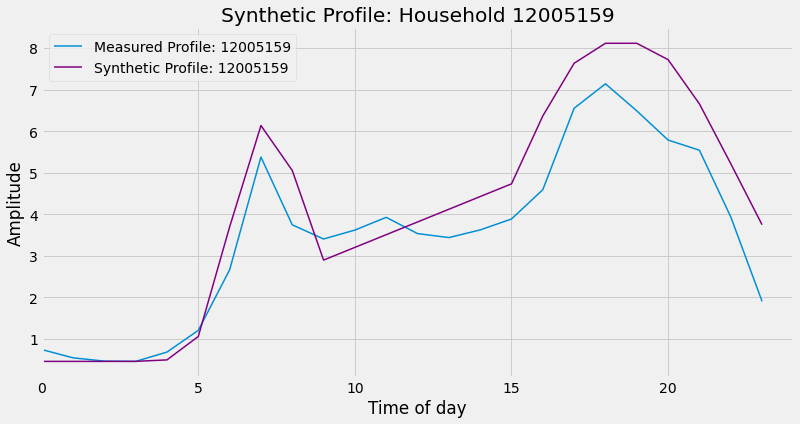

In [ ]:
# Measured Mean profile
X = cleaned_df[cleaned_df["ProfileID"] == houseID]
mean_X = X.groupby(['ProfileID']).mean().values[0]

# build the plot
fig, ax = plt.subplots(figsize=(12,6))
plt.style.use('fivethirtyeight')  

# Plot the households loadprofile
fig = plt.plot(mean_X, linewidth = 1.5, label = "Measured Profile: " + str(houseID))#, linestyle = 'dashed')
plt.title("Household "+str(houseID))
x_all = np.arange(0,24,1)
# Plot Gauss Fit
ax.plot(x_all,synth_mean,linewidth = 1.5, color = 'purple',label = "Synthetic Profile: " + str(houseID))# + ", RMSE = " + str('{0:.3g}'.format(RMSE)))

plt.legend(loc = "upper left")
# Set the labels and axis limits
ax.set_xlim([0,24])
ax.set_xlabel('Time of day')
ax.set_ylabel("Amplitude")
ax.set_title('Synthetic Profile: Household ' + str(houseID))

# # Save the figure
# plt.savefig('Synthetic Profile' + str(houseID) + '.png', dpi=72, bbox_inches='tight')
plt.show()

#### Check the error of the synthetic vs actual


In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)



In [ ]:
from sklearn.metrics import mean_squared_error
actual = mean_X
predicted = synth_mean
MSE = mean_squared_error(actual, predicted)
RMSE = math.sqrt(MSE)
MAPE = mean_absolute_percentage_error(actual, predicted)
sMAPE = smape(actual, predicted)

In [ ]:
sMAPE

21.392736050375635

#### Check the total daily energy error of the mean vs synthetic profile

In [ ]:
Eactual = actual.sum()
Esynth = synth_mean.sum()

percentage_error = abs(Eactual - Esynth)/Eactual*100
percentage_error

18.348702138560398

## Plot the results of the fitted distribution

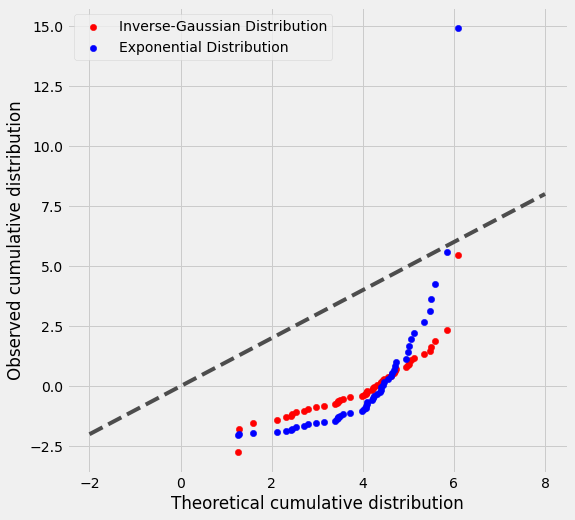

In [ ]:
data_points = expon.rvs(-2.024, 2.02402, size=2000)   # (-2.024029952926784, 2.0240299529267833)
data_points2 = invgauss.rvs(0.0291, -5.805, 199.178,size = 2000) # 0.029144801515814635, -5.80502010913426, 199.17870918874007

f, ax = plt.subplots(figsize=(8,8))
ax.plot([-2, 8], [-2, 8], ls="--", c=".3")

percentile_bins = np.linspace(0,100,51)
percentile_cutoffs1 = np.percentile(y_std, percentile_bins)
percentile_cutoffs_expon= np.percentile(data_points, percentile_bins)


percentile_cutoffs_invgauss = np.percentile(data_points2, percentile_bins)


ax.scatter(percentile_cutoffs1,percentile_cutoffs_invgauss,c='r',label = 'Inverse-Gaussian Distribution',s = 40)
ax.scatter(percentile_cutoffs1,percentile_cutoffs_expon,c='b',label = 'Exponential Distribution',s = 40)


ax.set_xlabel('Theoretical cumulative distribution')
ax.set_ylabel('Observed cumulative distribution')
ax.legend()
plt.show()

1.0939473068569046 0.25298669830354836 0.17024613890652113


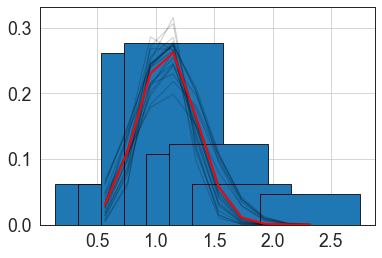

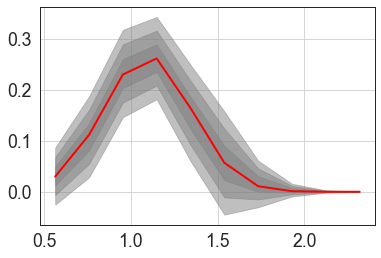

In [ ]:
from fitter import HistFit
from pylab import hist
import scipy.stats
data = dataset.loc[12004882]['A1'].values#[scipy.stats.norm.rvs(2,3.4) for x in  range(10000)]
Y, X, _ = hist(data, bins=10)
hf = HistFit(X=X, Y=Y)
hf.fit(error_rate=0.03, Nfit=20)
print(hf.mu, hf.sigma, hf.amplitude)

In [ ]:
# def extract_all_amplitudes(df,id):

#     A1, A2, mu1, mu2 = extractToPs(df, id)

#     data=[[id, A1, A2, mu1, mu2]]

#     temp_df = pd.DataFrame(data, columns=cols)
#     temp_df.set_index(['ProfileID'])
#     gauss_df = gauss_df.append(temp_df)

In [ ]:
# for id in reduced_list:
#     for row in cleaned_df.loc[id]:
#         print(row)


### Winter Weekdays

In [ ]:
# path =r'C:\Users\Jason\thesis_project\data\features\FitFeatures\Winter_Weekdays'
# list_files = []
# for root, dirs, files in os.walk(path):
# 	for file in files:
# 		list_files.append(os.path.join(root,file))

# dfs = []
# res = ''
# for name in list_files:
#     temp_df = pd.read_csv(name,header=[0, 1], index_col = 0)
#     dfs.append(temp_df)

# res = pd.concat(dfs, ignore_index=False)  # concatenate list of dataframes

# res

# Get the amplitude deviation

### Winter-weekdays

In [ ]:
# X.reset_index(inplace = True)

# df = X.copy()

# # Extract Season
# df['month'] = df.date.dt.month
# df['season'] = df['month'].apply(lambda x: 'winter' if x in [6, 7, 8] else 'summer') 
# df_winter = df[df['season'] == 'winter'] # Create dataframe with all the winter months, excluding weekends


# # Extract Weekdays
# weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday','Friday']
# df_winter['day_names'] = df_winter.date.dt.day_name()
# df_winter['daytype'] = df_winter.day_names.where(~df_winter.day_names.isin(weekdays), 'weekday')
# df_winter.drop(['day_names'], axis = 1, inplace = True)
# df_winter_weekdays  = df_winter[df_winter['daytype'] == 'weekday'] # Create dataframe with only weekdays
# df_winter_weekdays.drop(['month', 'season','daytype'], axis = 1, inplace = True)
# df_winter_weekdays.set_index(['ProfileID','date'], inplace=True)

# # df_winter_weekdays.to_csv("Winter_Weekdays_Dataframe.csv")


# Extract the amplitude devition

In [ ]:
# # Get the profile IDs
# ids = res.index.values

In [ ]:
# df_winter_weekdays.reset_index(["date"],inplace = True)

In [ ]:
# df_winter_weekdays = df_winter_weekdays[df_winter_weekdays.index.isin(ids)]

In [ ]:
# df_winter_weekdays.drop(['date'],axis = 1,inplace = True)

In [ ]:
# df_winter_weekdays.reset_index(inplace = True)

In [ ]:
# df_mean = df_winter_weekdays.groupby(['ProfileID']).mean()